In [1]:
#coding utf8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, metrics
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.feature_selection import mutual_info_regression, f_regression, r_regression
import sklearn
#from PyIF import te_compute as te
#from neuralprophet import NeuralProphet


In [2]:
'''
Functions for loading in and combining data
'''
def load_df(file_name, sheet = 'Sheet 1'):
    '''
    Load a file into a data frame that is quarterly from the Eurostat website
    '''
    df = pd.read_excel(file_name, sheet_name=sheet)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.replace(':', np.nan, inplace=True)
    df.index = df.iloc[:, 0]
    df.drop(df.columns[[0]], axis=1, inplace=True)
    for i in df.columns[:]:
        df[i] = df[i].apply(pd.to_numeric, errors="coerce")
    df.interpolate(method='linear', inplace=True, axis = 1)
    df.sort_index(inplace=True)
    df = df.rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})
    return df

def create_per_employeer(GDP_df, HW_df, employees_df):
    ''' 
    Inputs: GDP, hours worked, and employees dataframes
    Output: dataframe with per-employee GDP and per hour worked GDP
    '''
    cols =(list(set(GDP_df.columns) and set(employees_df.columns) and set(HW_df.columns)))
    cols.sort()
    idx = cols.pop()
    per_employee_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    per_HW_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    for i in cols:
        per_employee_df[i] = GDP_df[i]/employees_df[i]
        per_HW_df[i] = per_employee_df[i]/HW_df[i]
    return per_employee_df, per_HW_df

def country_code_to_name(df):
    '''
    Renames country codes to country names
    '''
    df = df.rename({'AUT': 'Austria', 'BEL': 'Belgium', 'DEU': 'Germany','EST': 'Estonia','FIN': 'Finland','ESP': 'Spain','FRA': 'France','GRC': 'Greece','IRL': 'Ireland','ITA': 'Italy','LTU': 'Lithuania','LUX': 'Luxembourg','LVA': 'Latvia','PRT': 'Portugal','NLD': 'Netherlands','SVK': 'Slovakia','SVN': 'Slovenia','ISL': 'Iceland','GBR': 'United Kingdom','CHE': 'Switzerland','CZE': 'Cezch Republic','DNK': 'Denmark','HUN': 'Hungary','NOR': 'Norway','POL': 'Poland','SWE': 'Sweden'})
    return df

def yearly_to_quarterly(df):
    '''
    Inputs: df
    Converts the data from yearly to quarterly
    Outputs: quarterly_df
    '''
    data = df.to_numpy(dtype=np.float64)
    data = np.repeat(data, 4, axis = 1)
    quarterly_df = pd.DataFrame(data)
    quarterly_df.index = df.index
    quarterly_df.columns = GDP_df.columns[(int(df.columns[0]) - 1975)*4:(int(df.columns[-1]) - 2021)*4]
    return quarterly_df

def match_df(dfs):
    ''' 
    Input : dataframes
    This function matches dataframes by their index and column 
    Output: matched dataframes
    '''
    idx = set(dfs[0].index)
    cols = set(dfs[0].columns)
    for i in dfs:
        idx = idx.intersection(set(i.index))
        cols = cols.intersection(set(i.columns))
    cols = list(cols)
    idx = list(idx)
    cols.sort()
    idx.sort()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].loc[idx]
        dfs[i] = dfs[i][cols]
    return dfs

def to_datetime(df):
    df.columns = [w.replace('-Q1','-01') for w in df.columns]
    df.columns = [w.replace('-Q2','-04') for w in df.columns]
    df.columns = [w.replace('-Q3', '-07') for w in df.columns]
    df.columns = [w.replace('-Q4', '-10') for w in df.columns]
    for i in df.columns[:]:
        i = np.datetime64(i)
    df.columns = pd.to_datetime(df.columns)
    return df

def extend_df(dfs):
    idx = set(dfs[0].index)
    cols = set(dfs[0].columns)
    for i in dfs:
        idx = idx.union(set(i.index))
        cols = cols.union(set(i.columns))
    cols = list(cols)
    idx = list(idx)
    cols.sort()
    idx.sort()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].reindex(index=idx, columns=cols)
        dfs[i] = dfs[i].loc[idx]
        dfs[i] = dfs[i][cols]
        dfs[i] = to_datetime(dfs[i])
        dfs[i].interpolate(method='polynomial', order = 5, inplace = True, limit = 100, limit_direction = 'both', axis = 1)
        dfs[i].fillna(0)
    return dfs


In [3]:
'''
Functions for RNN time series prediction
'''
def process_data(X, y, split_point, time_step, data_memory):
    '''
    Inputs: X, y, split_point, time_step, data_memory
    Splits data into training and testing data
    Outputs: X_train, X_test, y_train, y_test
    '''
    X_norm, X_attrs, y_norm, y_attrs = normalise(X, y)
    split_point = int(X_norm.shape[0] *split_point)
    y_norm = np.roll(y_norm, -time_step)
    nrows = X_norm.shape[0]
    samples = X_norm.shape[1]
    X_norm = np.repeat(X_norm, data_memory, 0).reshape(nrows, data_memory, samples)
    x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, split_point)
    return x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs

def normalise(X, y):
    '''
    Inputs: X, y
    Normalises the data by subtracting the mean and dividing by the standard deviation
    Outputs : X_norm, y_norm, X_attrs, y_attrs
    '''
    X_attrs = np.zeros((X.shape[-1], 2))
    y_attrs = np.zeros((y.shape[-1], 2))
    X_norm = np.zeros(X.shape)
    y_norm = np.zeros(y.shape)
    for i in range(X.shape[-1]):
        X_attrs[i, :] = [np.mean(X[:, i]), np.var(X[:, i])]
        X_norm[:, i] = (X[:, i] - np.mean(X[:, i]))/np.var(X[:, i])**0.5
    for i in range(y.shape[-1]):
        y_attrs[i, :] = [np.mean(y[:, i]), np.var(y[:, i])]
        y_norm[:, i] = (y[:, i] - np.mean(y[:, i]))/np.var(y[:, i])**0.5 
    return X_norm, X_attrs, y_norm, y_attrs

def train_test_split(X, y, split_point):
    '''
    Splits the data into training and testing data
    '''
    x_train = X[:split_point, :, :]
    x_test = X[split_point:, :, :]
    y_train = y[:split_point]
    y_test = y[split_point:]
    return x_train, x_test, y_train, y_test
        
def create_model(layers, input_shape, print_summary):
    '''
    Creates a model with the specified layers
    '''
    model = keras.Sequential(layers)
    model.build(input_shape=input_shape)
    model.compile(loss='mse', optimizer='adam', metrics = [tf.keras.metrics.MeanSquaredError()])
    if print_summary:
        model.summary()
    return model

def run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point):
    '''
    Inputs: X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point
    Runs the model on the data
    Outputs: model, history
    '''
    x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs = process_data(X, y, split_point, time_step, data_memory)
    input_shape = (x_train.shape[0], data_memory, samples)
    model = create_model(model_layer, input_shape, print_summary)
    history = model.fit(x_train, y_train, validation_split = 0.1, epochs= epochs , batch_size=batch_size)
    y_pred_norm = np.concatenate((model.predict(x_train[:, :, :]), model.predict(x_test[:, :, :])))
    y_pred_norm = np.roll(y_pred_norm, 1, axis = 1)
    y_pred = y_pred_norm *y_attrs[:, 1]**0.5 + y_attrs[:, 0]
    return y_pred, history


In [4]:
'''
Regression stuff
'''

def run_regr(X, y, t, regr, colours):
    regr.fit(X, y)
    nrows = X.shape[0]
    y_reg = np.zeros(nrows)  
    for i in range(nrows):
        y_reg[i] = regr.predict(np.array([X[i, :]]))
    total_loss, loss = cal_loss(y, y_reg, nrows)
    plt.plot(t, y, colours[0], t, y_reg, colours[1])    
    return regr, total_loss, loss

def cal_loss(y, y_reg, nrows):
    abs_loss, per_loss = np.zeros(nrows), np.zeros(nrows)
    for i in range(nrows):
        abs_loss[i] = np.abs(y[i] - y_reg[i])
        if y[i] > 0:
            per_loss[i] = abs_loss[i] / y[i]
    total_loss, loss = np.sum(abs_loss)/ nrows, np.sum(per_loss)/ nrows
    return total_loss, loss

In [5]:
'''
Loads in gross domestic product, hours worked and employees data
Returns GDP per employee and GDP per hour worked
'''
GDP_df =  load_df('./data/GDP_per_quarter_2.xlsx') * 1e6
HW_df = load_df('./data/hours_worked.xlsx')
employees_df = load_df('./data/Employees.xlsx') * 1e3
per_employee_df, per_HW_df = create_per_employeer(GDP_df, HW_df, employees_df)

#per_HW_df.iloc[4, :].T.plot(legend = False)

In [6]:
'''
Depression data
'''
dep_df = pd.read_csv('data/depression_by_age.csv') 
dep_df = dep_df.drop(['Prevalence - Depressive disorders - Sex: Both - Age: 10 to 14 (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: All Ages (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: 70+ years (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent)', 'Prevalence - Depressive disorders - Sex: Both - Age: 15-49 years (Percent)'],axis=1)
a = ['Belgium','Bulgaria','Denmark','Germany','Estonia','Ireland','Greece','Spain','France','Croatia','Italy','Cyprus','Latvia','Lithuania','Luxemburg','Hungary','Malta','Netherlands','Austria','Poland','Portugal','Romania','Slovenia','Slovakia','Finland','Sweden','Iceland','Norway','Switzerland','United Kingdom','Montenegro','North Macedonia','Serbia','Turkey']
dep_df = dep_df[dep_df['Entity'].isin(a)]
dep_df['Age:15-69_depression_average']=dep_df.iloc[:,3:7].mean(axis=1,skipna=True)
dep_df = dep_df.pivot_table('Age:15-69_depression_average', ['Entity', 'Code'], 'Year')
dep_df = dep_df.reset_index('Code')
del dep_df['Code']
dep_quarterly_df = yearly_to_quarterly(dep_df)

'''
Education data
'''
education_dfs = [None] * 4
for i in range(4):
    education_dfs[i] = load_df('./data/Education.xlsx', 'Sheet ' + str(4*i + 1))
    education_dfs[i] = yearly_to_quarterly(education_dfs[i])
    education_dfs[i] = education_dfs[i].rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})
    

'''
Inflation data
'''
inf_df = pd.read_csv('data/Quarterly_infilation.csv')
inf_df =inf_df.drop(['SUBJECT', 'MEASURE','FREQUENCY','Flag Codes'], axis=1)
inf_df = inf_df.pivot_table('Value', ['LOCATION', 'INDICATOR'], 'TIME')
inf_df = country_code_to_name(inf_df)
inf_df = inf_df.reset_index('INDICATOR')
del inf_df['INDICATOR']
inf_df = inf_df.rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})

'''
Unemployment data
'''
unem_df = pd.read_csv('./data/unem.csv')
unem_df.fillna(0)
unem_df = unem_df[['LOCATION', 'TIME', 'Value']]
unem_df = unem_df.pivot_table('Value',  ['LOCATION'],'TIME')
unem_df = country_code_to_name(unem_df)

'''Wage data'''
wage_df = pd.read_csv('./data/wages_quarterly.csv')
wage_df.fillna(0)
wage_df = wage_df[['ref_area.label','time','obs_value' ]]
wage_df = wage_df.pivot_table('obs_value', index = ['ref_area.label'],columns = ['time'] )
wage_df = country_code_to_name(wage_df)
wage_quarterly_df = yearly_to_quarterly(wage_df)

wage_quarterly_df


,2008-Q1,2008-Q2,2008-Q3,2008-Q4,2009-Q1,2009-Q2,2009-Q3,2009-Q4,2010-Q1,2010-Q2,...,2017-Q3,2017-Q4,2018-Q1,2018-Q2,2018-Q3,2018-Q4,2019-Q1,2019-Q2,2019-Q3,2019-Q4
ref_area.label,,,,,,,,,,,,,,,,,,,,,
Austria,57.02,57.02,57.02,57.02,59.43,59.43,59.43,59.43,58.54,58.54,...,60.17,60.17,58.31,58.31,58.31,58.31,59.24,59.24,59.24,59.24
Belgium,65.43,65.43,65.43,65.43,66.10,66.10,66.10,66.10,65.18,65.18,...,61.61,61.61,61.55,61.55,61.55,61.55,61.86,61.86,61.86,61.86
Bulgaria,41.48,41.48,41.48,41.48,43.26,43.26,43.26,43.26,44.28,44.28,...,53.01,53.01,51.98,51.98,51.98,51.98,51.73,51.73,51.73,51.73
Croatia,59.68,59.68,59.68,59.68,61.96,61.96,61.96,61.96,60.98,60.98,...,54.83,54.83,57.38,57.38,57.38,57.38,57.82,57.82,57.82,57.82
Cyprus,55.27,55.27,55.27,55.27,58.37,58.37,58.37,58.37,57.14,57.14,...,48.44,48.44,49.16,49.16,49.16,49.16,49.74,49.74,49.74,49.74
Czechia,52.51,52.51,52.51,52.51,53.28,53.28,53.28,53.28,54.24,54.24,...,54.82,54.82,56.32,56.32,56.32,56.32,56.43,56.43,56.43,56.43
Denmark,61.04,61.04,61.04,61.04,63.48,63.48,63.48,63.48,59.94,59.94,...,56.69,56.69,56.46,56.46,56.46,56.46,56.19,56.19,56.19,56.19
Estonia,56.15,56.15,56.15,56.15,55.91,55.91,55.91,55.91,52.02,52.02,...,56.73,56.73,56.99,56.99,56.99,56.99,58.34,58.34,58.34,58.34
Finland,57.93,57.93,57.93,57.93,61.42,61.42,61.42,61.42,59.53,59.53,...,53.94,53.94,54.22,54.22,54.22,54.22,54.57,54.57,54.57,54.57


In [7]:
'''
Combine all dataframes and create a numpy array of the data
Data = [Country, Time, Feature]
'''
dfs = [per_employee_df, per_HW_df] + education_dfs + [inf_df, unem_df, dep_quarterly_df, wage_quarterly_df]
matched_dfs = match_df(dfs)
data = np.zeros((len(matched_dfs[0].index), len(matched_dfs[0].columns),  len(matched_dfs)))
for i in range(len(matched_dfs)):
    data[:, :, i] = matched_dfs[i].to_numpy(dtype=np.float64)
matched_dfs[1]


,2008-Q1,2008-Q2,2008-Q3,2008-Q4,2009-Q1,2009-Q2,2009-Q3,2009-Q4,2010-Q1,2010-Q2,...,2017-Q3,2017-Q4,2018-Q1,2018-Q2,2018-Q3,2018-Q4,2019-Q1,2019-Q2,2019-Q3,2019-Q4
TIME,,,,,,,,,,,,,,,,,,,,,
Austria,537.344956,563.244566,549.679923,574.753142,535.440455,548.677465,546.810112,583.284671,546.040840,568.177707,...,672.690971,715.115782,694.143873,694.903274,680.283683,735.279678,707.077815,712.706775,706.655983,745.302950
Belgium,611.402642,650.509000,611.189001,643.449734,609.283943,621.255617,609.988497,665.392445,616.821551,653.559524,...,724.471995,776.858710,733.940529,771.538079,727.325605,805.079956,759.323215,781.186857,751.422297,826.953821
Estonia,171.701788,190.377468,182.534316,178.910157,164.867715,176.504979,169.971297,183.658263,175.466804,191.819752,...,277.589863,293.317933,280.032487,304.915130,304.432135,320.218225,304.280370,330.497382,328.107378,339.227333
Finland,579.350013,586.306544,570.942422,621.474505,562.710294,566.491187,561.264723,623.490623,577.384773,591.012423,...,705.820527,760.885977,722.630770,722.863192,706.791371,772.158035,735.496109,744.788131,724.574777,796.554815
France,568.928419,571.953573,549.212748,573.509524,554.414509,556.772397,541.990617,584.201462,569.643620,578.276966,...,641.580188,676.407961,667.970758,666.923682,652.423829,694.526800,685.086642,688.967836,676.998156,706.971493
Germany,533.261691,537.787264,526.458031,525.027097,498.587068,498.165814,516.895246,521.901949,526.844000,530.364765,...,633.870803,652.256611,640.571441,651.784794,648.846794,663.996149,656.987494,662.946576,670.291155,670.776516
Greece,450.237773,475.350999,493.613691,494.032784,431.791418,479.375864,484.782423,510.227724,454.466483,467.887041,...,445.081227,435.830798,404.962170,418.280658,438.439335,426.930667,393.208134,412.272885,439.291495,417.200137
Ireland,730.837838,712.962459,709.483959,717.768395,729.491893,737.183130,730.276180,725.745522,751.570211,748.128309,...,1142.165178,1194.916464,1185.451518,1136.597987,1210.725858,1198.363725,1223.917587,1195.186922,1296.389764,1293.331757
Italy,614.724780,633.805433,602.236385,651.236052,585.712091,607.700298,600.325440,655.454294,601.425367,636.596891,...,651.496704,706.558201,653.060782,663.700334,656.601482,718.317815,658.660202,671.429938,668.084421,722.759252


In [8]:
print(data[0, :, 2:])
pd.DataFrame(data[0, :, 2:])


[[2.65000000e+01 7.35000000e+01 5.89000000e+01 1.46000000e+01
  3.32139400e+00 4.53333300e+00 3.93294770e+00 5.70200000e+01]
 [2.65000000e+01 7.35000000e+01 5.89000000e+01 1.46000000e+01
  3.60592400e+00 4.06666700e+00 3.93294770e+00 5.70200000e+01]
 [2.65000000e+01 7.35000000e+01 5.89000000e+01 1.46000000e+01
  3.72870500e+00 4.36666700e+00 3.93294770e+00 5.70200000e+01]
 [2.65000000e+01 7.35000000e+01 5.89000000e+01 1.46000000e+01
  2.22222200e+00 4.73333300e+00 3.93294770e+00 5.70200000e+01]
 [2.55000000e+01 7.45000000e+01 5.88000000e+01 1.56000000e+01
  1.10305700e+00 5.06666700e+00 3.89439805e+00 5.94300000e+01]
 [2.55000000e+01 7.45000000e+01 5.88000000e+01 1.56000000e+01
  2.79676800e-01 5.70000000e+00 3.89439805e+00 5.94300000e+01]
 [2.55000000e+01 7.45000000e+01 5.88000000e+01 1.56000000e+01
  3.09885300e-02 6.13333300e+00 3.89439805e+00 5.94300000e+01]
 [2.55000000e+01 7.45000000e+01 5.88000000e+01 1.56000000e+01
  6.21118000e-01 5.83333300e+00 3.89439805e+00 5.94300000e+01]


,0,1,2,3,4,5,6,7
0,26.5,73.5,58.9,14.6,3.321394,4.533333,3.932948,57.02
1,26.5,73.5,58.9,14.6,3.605924,4.066667,3.932948,57.02
2,26.5,73.5,58.9,14.6,3.728705,4.366667,3.932948,57.02
3,26.5,73.5,58.9,14.6,2.222222,4.733333,3.932948,57.02
4,25.5,74.5,58.8,15.6,1.103057,5.066667,3.894398,59.43
5,25.5,74.5,58.8,15.6,0.279677,5.700000,3.894398,59.43
6,25.5,74.5,58.8,15.6,0.030989,6.133333,3.894398,59.43
7,25.5,74.5,58.8,15.6,0.621118,5.833333,3.894398,59.43
8,24.8,75.2,59.4,15.9,1.402743,5.366667,3.874706,58.54
9,24.8,75.2,59.4,15.9,1.952278,5.300000,3.874706,58.54


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
# normalise data 

# scaler = StandardScaler()
# scaler = preprocessing.MinMaxScaler()
# normalised_data = scaler.fit_transform(data[0, :, :])

510.69232691674574
0
[57.791175746763244, 1929.6632638841163, 897.212424644799, 186.12070303467053, 105.053144620977, 654.4890893819197, 1497.8146043358543, 6.162008918366137, 4.317242267436709, 214.13605564040006, 134.17447743865813, 441.37373308698784] test_loss
scores [-7.06171785e-01 -5.48215074e+00  3.41531588e-03 -1.79473605e+00
 -2.04019189e+01]
0.8669559600112179


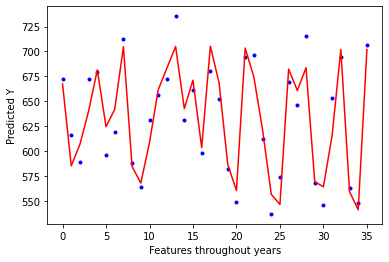

,Columns,Coefficient Estimate
0,0,6.608071e+14
1,1,6.608071e+14
2,2,-7.451217e+01
3,3,-1.391787e+02
4,4,7.935706e+00
5,5,-8.340771e-02
6,6,7.424689e+00
7,7,-1.760214e+00


In [10]:
'''Linear Regression Coefficients for Austria'''
# import ridge regression from sklearn library
from sklearn.linear_model import Ridge
# import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

scaler = StandardScaler()

# Y = gdp_df
X = data[0, :, 2:]
# Output : Productivity GDP
Y = data[0, :, 1]

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=4)

x_train = pd.DataFrame(x_train)
x_train_normalized = pd.DataFrame(scaler.fit_transform(x_train), columns= x_train.columns)
x_test = pd.DataFrame(x_test)
x_test_normalized = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

# Train Linear Model
reg = LinearRegression()
reg.fit(x_train_normalized, y_train)
y_pred = reg.predict(x_test_normalized)
y_pred_train = reg.predict(x_train_normalized)


# calculate mean square error
mean_squared_error_ridge = np.mean((y_pred - y_test)**2)
print(mean_squared_error_ridge)

count = 0
# tl = []
test_loss = []
for i in range(len(y_pred)):
    test_loss.append((y_pred[i] - y_test[i])**2)
    # tl.append( F.mse_loss(y_pred[i], y_test[i]))
    if (y_pred_train[i] - y_train[i]) == 0 :
        count += 1
print(count)
print(test_loss, "test_loss")
# print(tl)

# Create KFold object with 5 splits
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
scores = cross_val_score(reg, x_test_normalized, y_test, cv=folds)
print('scores', scores)

# get ridge coefficient and print them
reg_coefficient = pd.DataFrame()
reg_coefficient["Columns"]= x_train_normalized.columns
reg_coefficient['Coefficient Estimate'] = pd.Series(reg.coef_)

print(reg.score(x_test_normalized, y_test))
reg_coefficient
values = [0,1,2,3,4,]
# plt.plot(x_w, test_loss)
# plt.plot(values, scores)
# plt.scatter(x_test_normalized, y_pred)
# plt.plot(x_test_normalized[1], y_pred)
# plt.scatter(x_test_normalized[1], y_pred)
# plt.show()
x_ax = range(len(x_test[5]))
# plt.plot(x_ax, y_test, '.', color= 'blue')
# plt.plot(x_ax, y_pred, 'r')
x_ax_train= range(len(x_train[5])) 
# a= GDP_df.columns
# a = a[132:168]
plt.plot(x_ax_train, y_train, '.', color= 'blue')
plt.plot(x_ax_train, y_pred_train, 'r')
plt.xlabel('Features throughout years')
plt.ylabel('Predicted Y')
plt.savefig('linear_regression_austria.png', format='png')
plt.show()
reg_coefficient



In [11]:
# linear loss = 506.6576999353461, ridge loss = 492.1105036763902, lasso loss = 401913.4517604071, elastic loss= 676.79142099252

In [12]:
'''x_w = [0,1,2,3,4,5,6,7,8,9,10,11]
plt.plot(x_w, test_loss)
plt.show()'''


'x_w = [0,1,2,3,4,5,6,7,8,9,10,11]\nplt.plot(x_w, test_loss)\nplt.show()'

307.56070566142387
0
[427.0265949842555, 1005.2634321228333, 436.94069675907946, 151.04457590472208, 20.728066015465224, 499.3782524236048, 250.0661723928259, 4.577136785872216, 48.22812095202493, 366.6082681091637, 468.3699163800695, 12.497235107169573] test_loss
0.8635789276488129


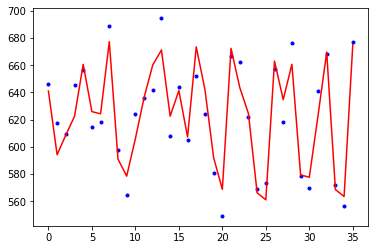

,Columns,Coefficient Estimate
0,0,-8.714118
1,1,8.714118
2,2,-0.557594
3,3,12.138618
4,4,5.543945
5,5,3.174547
6,6,-4.665007
7,7,-7.995852


In [13]:
'''Ridge Regression Coefficients for Austria'''
# import ridge regression from sklearn library
from sklearn.linear_model import Ridge

scaler = StandardScaler()

# Y = gdp_df
X = data[4, :, 2:]
# Output : Productivity GDP
Y = data[4, :, 1]

#X = data[:, 2:]
# Output : Productivity GDP
# Y = data[:, 1]

# X_norm = preprocessing.normalize(X)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=4)

x_train = pd.DataFrame(x_train)
x_train_normalized = pd.DataFrame(scaler.fit_transform(x_train), columns= x_train.columns)
x_test = pd.DataFrame(x_test)
x_test_normalized = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)


# Train the model
ridgeR = Ridge(alpha = 1)
ridgeR.fit(x_train_normalized, y_train)
y_pred = ridgeR.predict(x_test_normalized)
y_pred_train = ridgeR.predict(x_train_normalized)


# calculate mean square error
mean_squared_error_ridge = np.mean((y_pred - y_test)**2)
print(mean_squared_error_ridge)

count = 0
# tl = []
test_loss = []
for i in range(len(y_pred)):
    test_loss.append((y_pred[i] - y_test[i])**2)
    # tl.append( F.mse_loss(y_pred[i], y_test[i]))
    if (y_pred[i] - y_test[i]) == 0 :
        count += 1
print(count)
print(test_loss, "test_loss")
# print(tl)


# x_w = [0,1,2,3,4,5,6,7,8,9,10,11]
# plt.plot(x_w, test_loss)
# plt.show()

# get ridge coefficient and print them
ridge_coefficient = pd.DataFrame()
ridge_coefficient["Columns"]= x_train_normalized.columns
ridge_coefficient['Coefficient Estimate'] = pd.Series(ridgeR.coef_)

print(ridgeR.score(x_test_normalized, y_test))
x_ax = range(len(x_test[5]))
x_ax_train= range(len(x_train[5])) 
plt.plot(x_ax_train, y_train, '.', color= 'blue')
plt.plot(x_ax_train, y_pred_train, 'r')
plt.show()
ridge_coefficient


In [14]:
ridge_coefficient = ridge_coefficient.rename(index={0:'Less than Basic Education'})
ridge_coefficient = ridge_coefficient.rename(index={1:'Basic Education'})
ridge_coefficient = ridge_coefficient.rename(index={2:'Intermediate Education'})
ridge_coefficient = ridge_coefficient.rename(index={3:'Advanced Education'})
ridge_coefficient = ridge_coefficient.rename(index={4:'Inflation'})
ridge_coefficient = ridge_coefficient.rename(index={5:'Unemployement'})
ridge_coefficient = ridge_coefficient.rename(index={6:'Depression'})
ridge_coefficient = ridge_coefficient.rename(index={7:'Wages'})



ridge_coefficient

,Columns,Coefficient Estimate
Less than Basic Education,0,-8.714118
Basic Education,1,8.714118
Intermediate Education,2,-0.557594
Advanced Education,3,12.138618
Inflation,4,5.543945
Unemployement,5,3.174547
Depression,6,-4.665007
Wages,7,-7.995852


In [15]:
averadge_GDP = np.mean(Y)
averadge_GDP


620.8280246245772

In [16]:
absolute = np.abs(ridge_coefficient)
absolute
sum_values = np.sum(absolute)
ridge_coefficient['percentages'] = (absolute['Coefficient Estimate']) / sum_values['Coefficient Estimate'] 
ridge_coefficient['As a percentage of GDP'] = ridge_coefficient['percentages'] * averadge_GDP
# ridge_coefficient
ridge_coefficient

,Columns,Coefficient Estimate,percentages,As a percentage of GDP
Less than Basic Education,0,-8.714118,0.169194,105.040187
Basic Education,1,8.714118,0.169194,105.040187
Intermediate Education,2,-0.557594,0.010826,6.721249
Advanced Education,3,12.138618,0.235684,146.319192
Inflation,4,5.543945,0.107641,66.826843
Unemployement,5,3.174547,0.061637,38.266066
Depression,6,-4.665007,0.090576,56.232111
Wages,7,-7.995852,0.155248,96.382190


In [17]:
# Regressions for all countries 
from sklearn.linear_model import Lasso
emp = pd.DataFrame()
bar =  []
scaler = StandardScaler()

# looping through the countries
for i in range (15):
    X = data[i, :, 2:]
    Y = data[i, :, 1]
    # X_norm = preprocessing.normalize(X)
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=4)
    
    x_train = pd.DataFrame(x_train)
    x_train_normalized = pd.DataFrame(scaler.fit_transform(x_train), columns= x_train.columns)
    x_test = pd.DataFrame(x_test)
    x_test_normalized = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)


    # Train the model: just change RidgeR= Lasso(alpha=1) for Lasso regression, RidgeR = Ridge(alpha=1) for ridge 
    # and RidgeR = LinearRegression() for linear regression
    ridgeR = Ridge(alpha=1)
    ridgeR.fit(x_train_normalized, y_train)
    y_pred = ridgeR.predict(x_test_normalized)

    # calculate mean square error
    mean_squared_error_ridge = np.mean((y_pred - y_test)**2)
    #print(mean_squared_error_ridge)
    
    # Create KFold object with 5 splits : default value of score is 'neg_mean_squared_error'--> 
    # which is teh mean squared error whith a minus sign in front of it. 
    # you can change score to score='neg_r2_score' i think or smt like this 
    folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
    scores = cross_val_score(ridgeR, x_test_normalized, y_test, cv=folds)
    print('scores', np.mean(scores))


    x_train_normalized = pd.DataFrame(x_train_normalized)
    # get ridge coefficient and print them
    ridge_coefficient = pd.DataFrame()
    ridge_coefficient["Columns"]= x_train_normalized.columns
    ridge_coefficient['Coefficient Estimate'] = pd.Series(ridgeR.coef_)
    r = ridge_coefficient['Coefficient Estimate'].values
    #print(r)
    #r = ridge_coefficient.drop(['Columns'], axis=1)
    avgGDP = np.mean(Y)

    a= np.abs(r)
    
    s = np.sum(a)
    divide= (a/s)*100
    divide = (divide*avgGDP)/100
    bar.append(divide)

# Find the mean of all the mean squared errors for all countries, so hat you have one value for the score 
score = np.mean(scores)  
print(score)
print(np.shape(bar))
please = pd.DataFrame(bar)
please

scores -5.676312434676403
scores -45.339611631867214
scores -43.39200584481317
scores -119.62946210560858
scores -20.675659770077573
scores -1045359.2502262415
scores -3.660990606060833
scores -961.9978926641743
scores -81.40866122783471
scores -23361.475629476172
scores -1124.0559634801593
scores -18.664180419904046
scores -6684.301650838526
scores -19.59804831858052
scores -76.98561718229442
-76.98561718229442
(15, 8)


,0,1,2,3,4,5,6,7
0,208.710735,208.710735,34.232175,51.277374,49.528722,7.397683,31.296835,38.890449
1,146.015865,146.015865,59.192599,147.933668,45.936846,26.441311,53.135152,74.789941
2,36.182949,36.182949,51.769099,53.435428,16.276373,5.405884,16.517325,19.936843
3,87.594652,87.594652,75.258557,88.359844,58.947794,9.805963,154.660979,103.320364
4,105.040187,105.040187,6.721249,146.319192,66.826843,38.266066,56.232111,96.382190
5,16.731271,16.731271,20.766188,29.479071,9.088216,374.568711,107.162947,13.005136
6,47.589323,47.589323,6.272449,92.524419,59.726079,90.135823,103.054386,9.227991
7,28.534965,28.534965,6.358943,29.543595,23.059902,103.084648,152.554368,556.814717
8,73.492971,73.492971,210.706575,10.278702,110.945422,120.445684,30.931641,23.307561
9,40.465029,40.465029,26.310705,38.158505,24.524179,12.563826,7.990277,7.967571


In [18]:
emp = pd.DataFrame()
bar =  []
scaler = StandardScaler()
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.linear_model import Lasso

for i in range (15):
    X = data[i, :, 2:]
    Y = data[i, :, 1]
    # X_norm = preprocessing.normalize(X)
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=4)
    
    x_train = pd.DataFrame(x_train)
    x_train_normalized = pd.DataFrame(scaler.fit_transform(x_train), columns= x_train.columns)
    x_test = pd.DataFrame(x_test)
    x_test_normalized = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)


    # Train the model
    ridgeR = Ridge(alpha = 1.0)
    ridgeR.fit(x_train_normalized, y_train)
    y_pred = ridgeR.predict(x_test_normalized)

    # calculate mean square error
    mean_squared_error_ridge = np.mean((y_pred - y_test)**2)
    #print(mean_squared_error_ridge)
    
    # Create KFold object with 5 splits
    folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
    scores = cross_val_score(ridgeR, x_test_normalized, y_test, cv=folds)
    # print('scores', np.mean(scores))


    x_train_normalized = pd.DataFrame(x_train_normalized)
    # get ridge coefficient and print them
    ridge_coefficient = pd.DataFrame()
    ridge_coefficient["Columns"]= x_train_normalized.columns
    ridge_coefficient['Coefficient Estimate'] = pd.Series(ridgeR.coef_)
    r = ridge_coefficient['Coefficient Estimate'].values
    #print(r)
    #r = ridge_coefficient.drop(['Columns'], axis=1)
    avgGDP = np.mean(Y)

    a= np.abs(r)
    
    s = np.sum(a)
    divide= (a/s)*100
    divide = (divide*avgGDP)/100
    bar.append(divide)

    
# score = np.mean(scores)  
# print(score)

print(np.shape(bar))
please = pd.DataFrame(bar)
please
please['sum'] = please.sum(axis=1)
please


(15, 8)


,0,1,2,3,4,5,6,7,sum
0,208.710735,208.710735,34.232175,51.277374,49.528722,7.397683,31.296835,38.890449,630.044708
1,146.015865,146.015865,59.192599,147.933668,45.936846,26.441311,53.135152,74.789941,699.461247
2,36.182949,36.182949,51.769099,53.435428,16.276373,5.405884,16.517325,19.936843,235.706850
3,87.594652,87.594652,75.258557,88.359844,58.947794,9.805963,154.660979,103.320364,665.542805
4,105.040187,105.040187,6.721249,146.319192,66.826843,38.266066,56.232111,96.382190,620.828025
5,16.731271,16.731271,20.766188,29.479071,9.088216,374.568711,107.162947,13.005136,587.532811
6,47.589323,47.589323,6.272449,92.524419,59.726079,90.135823,103.054386,9.227991,456.119793
7,28.534965,28.534965,6.358943,29.543595,23.059902,103.084648,152.554368,556.814717,928.486104
8,73.492971,73.492971,210.706575,10.278702,110.945422,120.445684,30.931641,23.307561,653.601526
9,40.465029,40.465029,26.310705,38.158505,24.524179,12.563826,7.990277,7.967571,198.445121


In [19]:

p = please.sort_values(by=['sum'])
p

,0,1,2,3,4,5,6,7,sum
9,40.465029,40.465029,26.310705,38.158505,24.524179,12.563826,7.990277,7.967571,198.445121
10,31.101880,31.101880,18.878256,38.103473,37.839054,7.653908,37.294086,4.526598,206.499136
2,36.182949,36.182949,51.769099,53.435428,16.276373,5.405884,16.517325,19.936843,235.706850
12,43.645134,43.645134,73.730329,23.320085,3.782358,17.775091,69.687919,37.393545,312.979596
13,58.876146,58.876146,6.940860,34.079574,17.455405,76.853737,61.545486,0.075595,314.702948
6,47.589323,47.589323,6.272449,92.524419,59.726079,90.135823,103.054386,9.227991,456.119793
14,56.812100,56.812100,73.451442,28.621567,12.153674,96.071859,10.441672,135.479422,469.843837
5,16.731271,16.731271,20.766188,29.479071,9.088216,374.568711,107.162947,13.005136,587.532811
4,105.040187,105.040187,6.721249,146.319192,66.826843,38.266066,56.232111,96.382190,620.828025
0,208.710735,208.710735,34.232175,51.277374,49.528722,7.397683,31.296835,38.890449,630.044708


     greenBars  orangeBars    blueBars    pinkBars  purpleBars     redBars  \
9    40.465029   26.310705   26.310705   38.158505   24.524179   12.563826   
10   31.101880   18.878256   18.878256   38.103473   37.839054    7.653908   
2    36.182949   51.769099   51.769099   53.435428   16.276373    5.405884   
12   43.645134   73.730329   73.730329   23.320085    3.782358   17.775091   
13   58.876146    6.940860    6.940860   34.079574   17.455405   76.853737   
6    47.589323    6.272449    6.272449   92.524419   59.726079   90.135823   
14   56.812100   73.451442   73.451442   28.621567   12.153674   96.071859   
5    16.731271   20.766188   20.766188   29.479071    9.088216  374.568711   
4   105.040187    6.721249    6.721249  146.319192   66.826843   38.266066   
0   208.710735   34.232175   34.232175   51.277374   49.528722    7.397683   
8    73.492971  210.706575  210.706575   10.278702  110.945422  120.445684   
3    87.594652   75.258557   75.258557   88.359844   58.947794  

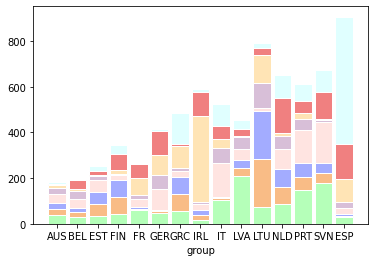

In [20]:
r = [0,1,2,3,4,5,6,7, 8,9,10,11,12,13,14]
raw_data = {'greenBars': p[0], 'orangeBars': p[2],'blueBars': p[2], 'pinkBars': p[3], 'purpleBars': p[4], 'redBars': p[5], 'yellowBars':p[6], 'brownBars':p[7]}
df = pd.DataFrame(raw_data)
print(df)

# plot
barWidth = 0.85
names = ('AUS','BEL','EST','FIN','FR','GER', 'GRC', 'IRL', 'IT', 'LVA', 'LTU', 'NLD', 'PRT', 'SVN', 'ESP')
# names = ('Austria','Belgium','Estonia','Finland','France','Germany', 'Greece', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Netherlands', 'Portugal', 'Slovenia', 'Spain')
# Create green Bars
plt.bar(r, df['greenBars'], color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, df['orangeBars'], bottom = df['greenBars'], color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
plt.bar(r, df['blueBars'], bottom = [i+j for i,j in zip(df['orangeBars'],  df['greenBars'])], color='#a3acff', edgecolor='white', width=barWidth)
plt.bar(r, df['pinkBars'], bottom = [i+j+k for i,j,k in zip(df['orangeBars'],  df['greenBars'], df['blueBars'])], color='MistyRose', edgecolor='white', width=barWidth)
plt.bar(r, df['purpleBars'], bottom = [i+j+k+l for i,j,k,l in zip(df['orangeBars'],  df['greenBars'], df['blueBars'], df['pinkBars'])], color='Thistle', edgecolor='white', width=barWidth)
plt.bar(r, df['redBars'], bottom = [i+j+k+l+o for i,j,k,l,o in zip(df['orangeBars'],  df['greenBars'], df['blueBars'], df['pinkBars'], df['purpleBars'])], color='moccasin', edgecolor='white', width=barWidth)
plt.bar(r, df['yellowBars'], bottom = [i+j+k+l+o+p for i,j,k,l,o,p in zip(df['orangeBars'],  df['greenBars'], df['blueBars'], df['pinkBars'], df['purpleBars'], df['redBars'])], color='LightCoral', edgecolor='white', width=barWidth)
plt.bar(r, df['brownBars'], bottom = [i+j+k+l+o+p+r for i,j,k,l,o,p,r in zip(df['orangeBars'],  df['greenBars'], df['blueBars'], df['pinkBars'], df['purpleBars'], df['redBars'], df['yellowBars'])], color='LightCyan', edgecolor='white', width=barWidth)
 
    
    
    
    
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
#plt.savefig('BARCHART_LASSO.png', format='png')
# Show graphic
plt.show()


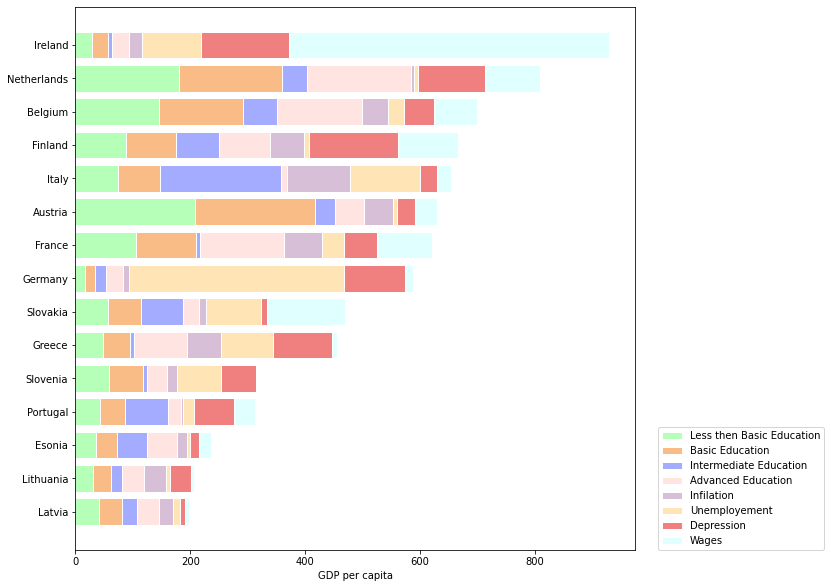

In [21]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

r = [0,1,2,3,4,5,6,7, 8,9,10,11,12,13,14]
raw_data = {'greenBars': p[0], 'orangeBars': p[1],'blueBars': p[2], 'pinkBars': p[3], 'purpleBars': p[4], 'redBars': p[5], 'yellowBars':p[6],'brownBars':p[7]}
df = pd.DataFrame(raw_data)


# plot

names = ('Latvia','Lithuania','Esonia','Portugal','Slovenia','Greece', 'Slovakia', 'Germany', 'France', 'Austria', 'Italy', 'Finland', 'Belgium', 'Netherlands', 'Ireland')
# names = ('Austria','Belgium','Estonia','Finland','France','Germany', 'Greece', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Netherlands', 'Portugal', 'Slovenia', 'Spain')
# Create green Bars
plt.barh(r, df['greenBars'], color='#b5ffb9', edgecolor='white',label='Less then Basic Education')
# Create orange Bars
plt.barh(r, df['orangeBars'], left= df['greenBars'], color='#f9bc86', edgecolor='white',label='Basic Education')
# Create blue Bars
plt.barh(r, df['blueBars'],left = [i+j for i,j in zip(df['orangeBars'],  df['greenBars'])], color='#a3acff', edgecolor='white',label='Intermediate Education')
plt.barh(r, df['pinkBars'], left= [i+j+k for i,j,k in zip(df['orangeBars'],  df['greenBars'], df['blueBars'])], color='MistyRose', edgecolor='white',label='Advanced Education')
plt.barh(r, df['purpleBars'], left = [i+j+k+l for i,j,k,l in zip(df['orangeBars'],  df['greenBars'], df['blueBars'], df['pinkBars'])], color='Thistle', edgecolor='white',label='Infilation')
plt.barh(r, df['redBars'], left = [i+j+k+l+o for i,j,k,l,o in zip(df['orangeBars'],  df['greenBars'], df['blueBars'], df['pinkBars'], df['purpleBars'])], color='moccasin', edgecolor='white',label='Unemployement')
plt.barh(r, df['yellowBars'], left = [i+j+k+l+o+p for i,j,k,l,o,p in zip(df['orangeBars'],  df['greenBars'], df['blueBars'], df['pinkBars'], df['purpleBars'], df['redBars'])], color='LightCoral', edgecolor='white',label='Depression')
plt.barh(r, df['brownBars'], left = [i+j+k+l+o+p+r for i,j,k,l,o,p,r in zip(df['orangeBars'],  df['greenBars'], df['blueBars'], df['pinkBars'], df['purpleBars'], df['redBars'], df['yellowBars'])], color='LightCyan', edgecolor='white', label='Wages')
 
    
    
    
    
# Custom x axis
# plt.title('Feature Importance according to Ridge regression')
plt.yticks(r, names)
plt.xlabel("GDP per capita")
#plt.savefig('BARCHART_LASSO.png', format='png')
# Show graphic
plt.legend(loc=(1.04,0))
plt.tight_layout()

# Save Plot

# plt.savefig('GDP_bar_Ridge.png', format='png')
plt.show()

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# plot a Stacked Bar Chart using matplotlib
please.plot(
    x = '0',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True)


KeyError: '0'

In [ ]:
# import libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# load dataset
please
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# set the figure size
plt.figure(figsize=(14, 14))

# top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
total = please.groupby('0')['total_bill'].sum().reset_index()

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="day",  y="total_bill", data=total, color='darkblue')

# bottom bar ->  take only smoker=Yes values from the data
smoker = tips[tips.smoker=='Yes']

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="day", y="total_bill", data=smoker, estimator=sum, ci=None,  color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='smoker = No')
bottom_bar = mpatches.Patch(color='lightblue', label='smoker = Yes')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

In [ ]:
'''Ridge Regression Coefficients for Estonia'''
# import ridge regression from sklearn library
from sklearn.linear_model import Ridge

scaler = StandardScaler()

# Y = gdp_df
X = data[2, :, 2:]
# Output : Productivity GDP
Y = data[2, :, 1]

#X = data[:, 2:]
# Output : Productivity GDP
# Y = data[:, 1]

# X_norm = preprocessing.normalize(X)

x_train1, x_test1, y_train_est, y_test_est = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=4)

x_train_est = pd.DataFrame(x_train1)
x_train_normalized_est = pd.DataFrame(scaler.fit_transform(x_train_est), columns= x_train_est.columns)
x_test_est = pd.DataFrame(x_test1)
x_test_normalized_est = pd.DataFrame(scaler.transform(x_test_est), columns=x_test_est.columns)


# Train the model
ridgeR = Ridge(alpha = 0.16363720)
ridgeR.fit(x_train_normalized_est, y_train)
y_pred_est = ridgeR.predict(x_test_normalized_est)

# calculate mean square error
mean_squared_error_ridge = np.mean((y_pred_est - y_test_est)**2)
print(mean_squared_error_ridge)

# get ridge coefficient and print them
ridge_coefficient_est = pd.DataFrame()
ridge_coefficient_est["Columns"]= x_train_normalized_est.columns
ridge_coefficient_est['Coefficient Estimate'] = pd.Series(ridgeR.coef_)

print(ridgeR.score(x_test_normalized_est, y_test_est))
ridge_coefficient_est

In [ ]:
ridge_coefficient_est = ridge_coefficient_est.rename(index={0:'Less than Basic Education'})
ridge_coefficient_est = ridge_coefficient_est.rename(index={1:'Basic Education'})
ridge_coefficient_est = ridge_coefficient_est.rename(index={2:'Intermediate Education'})
ridge_coefficient_est = ridge_coefficient_est.rename(index={3:'Advanced Education'})
ridge_coefficient_est = ridge_coefficient_est.rename(index={4:'Inflation'})
ridge_coefficient_est = ridge_coefficient_est.rename(index={5:'Unemployement'})
ridge_coefficient_est = ridge_coefficient_est.rename(index={6:'Depression'})
ridge_coefficient_est = ridge_coefficient_est.rename(index={7:'Wages'})


ridge_coefficient_est

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
color =['tab:gray', 'tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown','tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan','tab:orange', 'tab:green', 'tab:blue', 'tab:olive']
ax.bar(ridge_coefficient_est.index,
       ridge_coefficient_est['Coefficient Estimate'],
       color = color)
ax.spines['bottom'].set_position('zero')
ax.set_title('Ridge Regression Coefficients for Estonia')
plt.xlabel('Features')
plt.ylabel('Coefficient')
# plt.style.use('ggplot')
plt.savefig("Ridge_estonia.png", format= 'png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
color =['tab:gray', 'tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown','tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan','tab:orange', 'tab:green', 'tab:blue', 'tab:olive']
ax.bar(ridge_coefficient.index,
       ridge_coefficient['Coefficient Estimate'],
       color = color)
ax.spines['bottom'].set_position('zero')
ax.set_title('Ridge Regression Coefficients for Austria')
plt.xlabel('Features')
plt.ylabel('Coefficient')
# plt.style.use('ggplot')
plt.savefig("Ridge.png", format= 'png')
plt.show()


In [ ]:
'''from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.linear_model import LassoCV


''' Choose alpha '''
# Input = [Time, Feature]
X = data[0,:, 2:]
# Output : Productivity GDP
Y = data[0, :, 1]
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# cv_model = LassoCV(eps=0.001, n_alphas=100, alphas=np.logspace(-10, 1, 400), fit_intercept=False, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=5, verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')

cv_model = LassoCV(eps=0.001, n_alphas=100, alphas=[np.logspace(-10, 1, 400)], fit_intercept=True, normalize='deprecated', precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X_norm, Y, test_size=0.25, random_state=0)
model = Lasso(alpha=cv_model.alphas, fit_intercept=False, normalize=False, precompute=False, copy_X=True, max_iter=cv_model.max_iter, tol=0.0001, random_state=42, selection='cyclic')
model.fit(x_train, y_train)
print("score :",r2_score(y_train, model.predict(x_train)))
model.coef_
cv_model.fit(x_train, y_train)
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Number of iterations %d'%cv_model.n_iter_)'''

In [ ]:
# Lasso Regression coefficients
# import Lasso regression from sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

from sklearn import preprocessing

# Input = [Country, Time, Feature]
X = data[0,:, 2:]
# Output : Productivity GDP
Y = data[0, :, 1]
scaler = StandardScaler()

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=6)

x_train = pd.DataFrame(x_train)
x_train_normalized = pd.DataFrame(scaler.fit_transform(x_train), columns= x_train.columns)
x_test = pd.DataFrame(x_test)
x_test_normalized = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)


# Train the model
lasso = Lasso(alpha = 1, normalize='deprecated', fit_intercept = False)
lasso.fit(x_train_normalized, y_train)
y_pred = lasso.predict(x_test_normalized)

# Calculate Mean Squared Error / Validation Loss / Test Loss
mean_squared_error = np.mean((y_pred - y_test)**2)
print("Mean squared error on test set", mean_squared_error)
count = 0
# tl = []
test_loss = []
for i in range(len(y_pred)):
    test_loss.append((y_pred[i] - y_test[i])**2)
    # tl.append( F.mse_loss(y_pred[i], y_test[i]))
    if (y_pred[i] - y_test[i]) == 0 :
        count += 1
print(count)
print(test_loss, "test_loss")
# print(tl)

# x_w = [0,1,2,3,4,5,6,7,8,9,10,11]
# plt.plot(x_w, test_loss)
# plt.show()
x_train = pd.DataFrame(x_train_normalized)
lasso_coeff = pd.DataFrame()
lasso_coeff["Columns"] = x_train_normalized.columns
lasso_coeff['Coefficient Estimate'] = pd.Series(lasso.coef_)
print(lasso.score(x_test_normalized, y_test))
lasso_coeff

x_ax = range(len(x_test[5]))
plt.plot(x_ax, y_test, '.', color= 'blue')
plt.plot(x_ax, y_pred, 'r')
plt.show()


In [ ]:
lasso_coeff = lasso_coeff.rename(index={0:'Less than Basic Education'})
lasso_coeff = lasso_coeff.rename(index={1:'Basic Education'})
lasso_coeff = lasso_coeff.rename(index={2:'Intermediate Education'})
lasso_coeff = lasso_coeff.rename(index={3:'Advanced Education'})
lasso_coeff = lasso_coeff.rename(index={4:'Inflation'})
lasso_coeff = lasso_coeff.rename(index={5:'Unemployement'})
lasso_coeff = lasso_coeff.rename(index={6:'Depression'})


lasso_coeff

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
color =['tab:gray', 'tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown','tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan','tab:orange', 'tab:green', 'tab:blue', 'tab:olive']
ax.bar(lasso_coeff.index,
       lasso_coeff['Coefficient Estimate'],
       color = color)
ax.set_title('Lasso Regression Coefficients for Austria')
ax.spines['bottom'].set_position('zero')
plt.xlabel('Features')
plt.ylabel('Coefficient')
# plt.style.use('ggplot')
plt.savefig("Lasso.png", format= 'png')
plt.show()


In [ ]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
''''''
# Input = [Time, Feature]
X = data[0,:, 2:]
# Output : Productivity GDP
Y = data[ 0,:, 1]
scaler = StandardScaler()

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=4)
x_train = pd.DataFrame(x_train)
x_train_normalized = pd.DataFrame(scaler.fit_transform(x_train), columns= x_train.columns)
x_test = pd.DataFrame(x_test)
x_test_normalised = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)



cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=False, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=50, selection='cyclic')
cv_model.fit(x_train, y_train)
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

# l1 ratio = 1 means it is better to just use lasso

In [ ]:
from sklearn.metrics import r2_score
model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True, random_state=4)
model.fit(x_train_normalized, y_train)
print(r2_score(y_train, model.predict(x_train_normalized)))


In [ ]:
'''ELASTIC NET REGRESSION COEFFICIENTS'''
# import model
from sklearn.linear_model import ElasticNet
# dfs = per_employee_df, per_HW_df + education_dfs +inf_df, unem_df, dep_quarterly_df
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing


# Input = [Country, Time, Feature]
X = data[0, :, 2:]
# Output : Productivity GDP
Y = data[0, :, 1]
scaler = StandardScaler()

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=4)
'''
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:, :7], gdp_df.iloc[:,-1],
    test_size = 0.25, random_state=5)'''

# x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X_norm, Y, test_size=0.25, random_state=4)
x_train = pd.DataFrame(x_train)
x_train_normalized = pd.DataFrame(scaler.fit_transform(x_train), columns= x_train.columns)
x_test = pd.DataFrame(x_test)
x_test_normalised = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

# Train the model
e_net = ElasticNet(alpha = 1.04)
e_net.fit(x_train_normalized, y_train)
x_train = pd.DataFrame(x_train_normalized)
# calculate the prediction and mean square error
y_pred_elastic = e_net.predict(x_test_normalised)

mean_squared_error = np.mean((y_pred_elastic - y_test)**2)
print("Mean Squared Error on test set", mean_squared_error)

count = 0
# tl = []
test_loss = []
for i in range(len(y_pred)):
    test_loss.append((y_pred[i] - y_test[i])**2)
    # tl.append( F.mse_loss(y_pred[i], y_test[i]))
    if (y_pred[i] - y_test[i]) == 0 :
        count += 1
print(count)
print(test_loss, "test_loss")
# print(tl)

x_w = [0,1,2,3,4,5,6,7,8,9,10,11]
# plt.plot(x_w, test_loss)
# plt.show()
e_net_coeff = pd.DataFrame()
e_net_coeff["Columns"] = x_train_normalized.columns
e_net_coeff['Coefficient Estimate'] = pd.Series(e_net.coef_)
e_net_coeff
# plt.plot(X, )
x_ax = range(len(x_test[3]))
plt.plot(x_ax, y_test, '.')
plt.plot(x_ax, y_pred, 'r')
# plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
# plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")


# plt.scatter(x_test[3], y_pred)
# plt.plot(x_train_normalized.columns, e_net_coeff)
plt.show()


In [23]:
e_net_coeff = e_net_coeff.rename(index={0:'Less than Basic Education'})
e_net_coeff = e_net_coeff.rename(index={1:'Basic Education'})
e_net_coeff = e_net_coeff.rename(index={2:'Intermediate Education'})
e_net_coeff = e_net_coeff.rename(index={3:'Advanced Education'})
e_net_coeff = e_net_coeff.rename(index={4:'Inflation'})
e_net_coeff = e_net_coeff.rename(index={5:'Unemployement'})
e_net_coeff = e_net_coeff.rename(index={6:'Depression'})


e_net_coeff

NameError: name 'e_net_coeff' is not defined

NameError: name 'e_net_coeff' is not defined

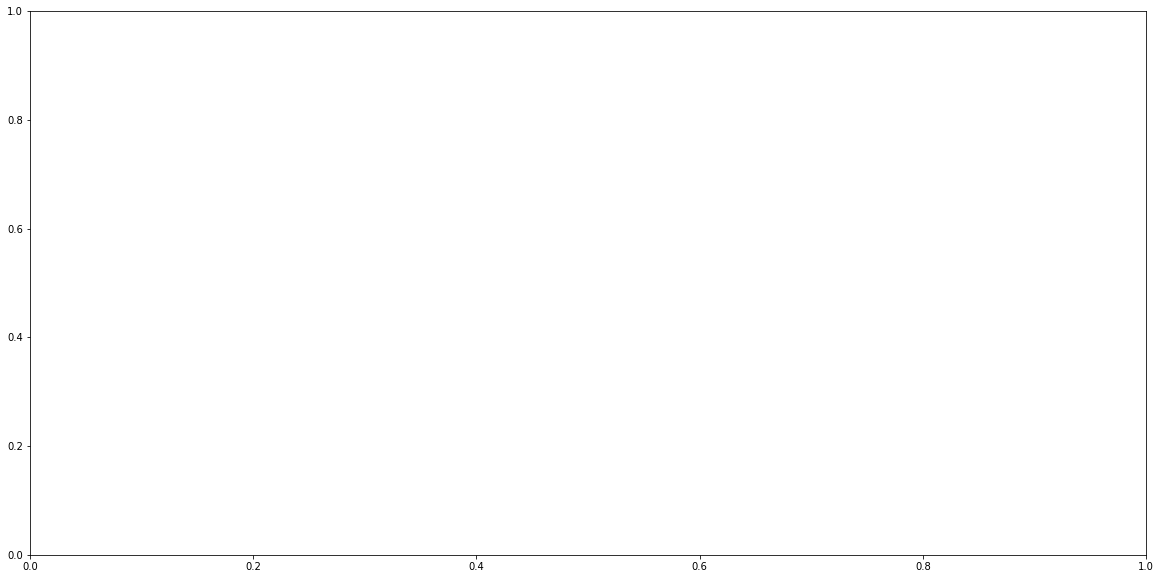

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
color =['tab:gray', 'tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown','tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan','tab:orange', 'tab:green', 'tab:blue', 'tab:olive']
ax.bar(e_net_coeff.index,
       e_net_coeff['Coefficient Estimate'],
       color = color)
ax.set_title('Elastic Net Regression Coefficients for Austria')
ax.spines['bottom'].set_position('zero')
plt.xlabel('Features')
plt.ylabel('Coefficient')
# plt.style.use('ggplot')
plt.savefig('ElasticNet.png', format='png')
plt.show()


In [ ]:
d = {'Less than basic education':[], 'Basic Education':[], 'Intermediate Education':[], 'Advanced Education': [], 'Inflation': [], 'Unemployment':[], 'Depression':[]}